## Loading the data

The data in this lab comes from neural recordings described in:

<a href="http://jn.physiology.org/content/106/2/764.short">
Stevenson, Ian H., et al. "Statistical assessment of the stability of neural movement representations." Journal of neurophysiology 106.2 (2011): 764-774</a>

In this experiment, the spikes were recorded from 196 neurons in the primary motor cortex (M1) of a monkey using an electrode array implanted onto the surface of a monkey's brain.  During the recording, the monkey performed several reaching tasks and the position and velocity of the hand was recorded as well.  

I try to predict the hand motion from the neural signals from the motor cortex.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [ ]:
fn_src = 'https://www.dropbox.com/sh/n4924ipcfjqc0t6/AADOv9JYMUBK1tlg9P71gSSra/example_data_s1.pickle?dl=1'
fn_dst = 'example_data_s1.pickle'

import os
from six.moves import urllib

if os.path.isfile(fn_dst):
    print('File %s is already downloaded' % fn_dst)
else:        
    urllib.request.urlretrieve(fn_src, fn_dst)

In [ ]:
with open('example_data_s1.pickle', 'rb') as fp:
    X,y = pickle.load(fp)

The matrix `X` is matrix of spike counts where `X[i,j]` is the number of spikes from neuron `j` in time bin `i`.
The matrix `y` has two columns:
* `y[i,0] = ` velocity of the monkey's hand in the x-direction
* `y[i,1] = ` velocity of the monkey's hand in the y-direction
  

In [ ]:
tsamp = 0.05  

nt = X.shape[0]
nneuron = X.shape[1]
nout = y.shape[1]
ttotal = y.shape[0] * tsamp

print("Total number of time bins : {}".format(nt))
print("Total number of neurons : {}".format(nneuron))
print("Total number of output variables to track : y : {}".format(nout))
print("Total time of the experiment in seconds : {} seconds".format(ttotal))

Total number of time bins : 61339
Total number of neurons : 52
Total number of output variables to track : y : 2
Total time of the experiment in seconds : 3066.9500000000003 seconds


## Fitting a Memoryless Linear Model

Trying a simple linear regression model to fit the data.

In [ ]:
from sklearn.model_selection import train_test_split

Xtr, Xts, ytr, yts = train_test_split(X, y, test_size = 0.33)

In [ ]:
regression = LinearRegression()
regression.fit(Xtr, ytr)
yhat = regression.predict(Xts)
rsq = r2_score(yts, yhat)
print("R^2 score : {}".format(rsq))

R^2 score : 0.4687054390950162


Text(0, 0.5, 'True velocity of hand in Y direction')

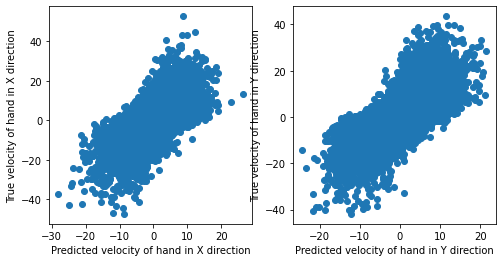

In [ ]:
plt.figure(figsize = (8, 4))
plt.subplot(1, 2, 1)
plt.plot(yhat[:, 0], yts[:, 0], 'o')
plt.xlabel("Predicted velocity of hand in X direction")
plt.ylabel("True velocity of hand in X direction")

plt.subplot(1, 2, 2)
plt.plot(yhat[:, 1], yts[:, 1], 'o')
plt.xlabel("Predicted velocity of hand in Y direction")
plt.ylabel("True velocity of hand in Y direction")

## Fitting Models with Delay

One way we can improve the model accuracy is to used delayed version of the features.  Specifically, the model we used above mapped the features 

    yhat[i,k] = \sum_{j=0}^{p-1} X[i,j]*w[j,k] + b[k]
    
where `p` is the number of features and `w[j,k]` is a matrix of coefficients.  In this model,  `yhat[i,:]` at time `i` was only dependent on the inputs  `X[i,:]` at time `i`.  In signal processing, this is called a *memoryless* model.  However, in many physical systems, such as those that arise in neuroscience, there is a delay between the inputs `X[i,:]` and the outputs `y[i]`.  For such cases, we can use a model of the form,

    yhat[i+d,k] = \sum_{j=0}^{p-1} \sum_{m=0}^d X[i+m,j]*W[j,m,k] + b[k]
    
where `W` is a 3-dim array of coefficients where:

    W[j,m,k] is the influence of the input X[i+m,j] onto output y[i+d,k]


In signal processing, this model is called an *FIR* filter and `W[j,:,k]` is the *impulse response* from the `j`-th input to the `k`-th output.  The point is that the output at time `i+d` depends on the inputs at times `i,i+1,...,i+d`.  Hence, it depends on the last `d+1` time steps, not just the most recent time. 


In [ ]:
def create_dly_data(X,y,dly):
    """
    Create delayed data
    """
    n, p = X.shape
    Xdly = np.zeros((n - dly, (dly + 1) * p))
    ydly = np.zeros((y.shape[0] - dly, y.shape[1]))
    for i in range(0, n - dly):
      Xdly[i, :] = np.reshape(X[i : i + dly + 1, :], (dly + 1) * p)
      ydly[i, :] = y[i + dly, :]
    return Xdly, ydly

In [ ]:
# fitting an linear delayed model with dly=6 additional delay lags

Xdly, ydly = create_dly_data(X, y, 6)
Xdly_train, Xdly_test, ydly_train, ydly_test = train_test_split(Xdly, ydly, test_size = 0.33)
regression.fit(Xdly_train, ydly_train)

ydly_hat = regression.predict(Xdly_test)
rsq_dly = r2_score(ydly_test, ydly_hat)
print("R^2 Score with 6 additional delay lags : {}".format(rsq_dly))

R^2 Score with 6 additional delay lags : 0.6939305263365129


Text(0, 0.5, 'True delayed velocity of hand in Y direction')

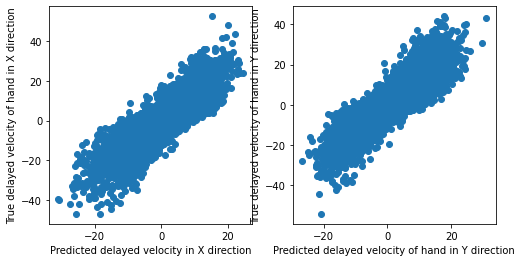

In [ ]:
plt.figure(figsize = (8, 4))
plt.subplot(1, 2, 1)
plt.plot(ydly_hat[:, 0], ydly_test[:, 0], 'o')
plt.xlabel("Predicted delayed velocity in X direction")
plt.ylabel("True delayed velocity of hand in X direction")

plt.subplot(1, 2, 2)
plt.plot(ydly_hat[:, 1], ydly_test[:, 1], 'o')
plt.xlabel("Predicted delayed velocity of hand in Y direction")
plt.ylabel("True delayed velocity of hand in Y direction")

## Selecting the Optimal Delay via Model Order Selection

Since we have a large number of data samples, the optimal model order uses a very high delay. Hence I use limited dataset in the beginning

In [ ]:
nred = 6000

Xred = X[: nred, :]
yred = y[: nred, :]

In [ ]:
import  sklearn.model_selection 
import tqdm.notebook

nfold = 5  # Number of folds
dmax = 15  # maximum number of delays

kf = sklearn.model_selection.KFold(n_splits = nfold)

dtest = np.arange(dmax + 1)
nd = len(dtest)

Rsq = np.zeros((nd, nfold))

# Creating a progress bar
pbar = tqdm.notebook.tqdm(
    total=nfold*nd, initial=0,
    unit='fits', unit_divisor=nd, desc='Model order test')


for it, d in enumerate(dtest):
    Xdly, ydly = create_dly_data(Xred, yred, d) 
        
    # Loop over the folds
    for isplit, Ind in enumerate(kf.split(Xdly)):

        # Get the training data in the split
        Itr, Its = Ind        

        Xtr = Xdly[Itr]
        ytr = ydly[Itr]
        Xts = Xdly[Its]
        yts = ydly[Its]
        
        regression.fit(Xtr, ytr)  

        y_hat = regression.predict(Xts)
        Rsq[it, isplit] = r2_score(yts, y_hat)
        
        pbar.update(1)
pbar.close()       

Computing the mean and standard error of the `R^2` values as a function of the model order `d`.  

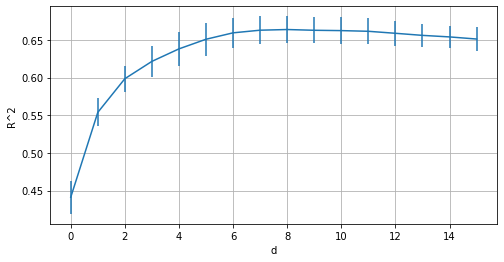

In [ ]:
Rsq_mean = np.mean(Rsq, axis = 1)
Rsq_std = np.std(Rsq, axis = 1)
plt.figure(figsize = (8, 4))
plt.errorbar(dtest, Rsq_mean, yerr = Rsq_std, fmt = '-')
plt.xlabel("d")
plt.ylabel("R^2")
plt.grid()

Finding the optimal order `d` with the normal rule (i.e. highest test `R^2`)

In [ ]:
max = np.argmax(Rsq_mean)
print("Optimal order with normal rule: {}".format(dtest[max]))

Optimal order with normal rule: 8
